### 🧠 09. Orchestration 2: Model Placement

As **super-agentic systems** scale, they often operate across a hierarchy of compute environments — from **on-device edge models** to **powerful cloud-scale LLMs**. Each layer offers a different trade-off between **latency**, **cost**, and **response quality**:

* ⚡ **Edge / On-Device SLMs** → low latency, low cost, privacy-preserving, but limited model capacity.
* ☁️ **Cloud LLMs** → high reasoning depth and accuracy, but higher latency and cost.

In an **agentic orchestration pipeline**, deciding *where* to run a given sub-task or prompt is just as critical as *which model* to run. This is known as **Model Placement** — the process of intelligently routing a request to the most appropriate compute layer based on context, workload, and desired trade-offs.


### 💡 Why Model Placement Matters in Super Agents

Modern **super agents**—multi-agent systems coordinating perception, reasoning, and action—require near-real-time responses while maintaining reliability and depth. In such systems:

| Challenge | Edge-Only | Cloud-Only  | Intelligent Placement |
| --------- | --------- | ----------- | --------------------- |
| Latency   | ✅ Fast    | ❌ Slow      | ⚖️ Adaptive           |
| Accuracy  | ❌ Limited | ✅ High      | ⚖️ Task-aware         |
| Cost      | ✅ Cheap   | ❌ Expensive | ⚖️ Budget-controlled  |
| Privacy   | ✅ Local   | ❌ Shared    | ⚖️ Policy-driven      |

A well-designed placement policy helps super agents:

* ⚖️ **Balance response quality and latency** dynamically.
* 💸 **Optimize cost and energy efficiency** across distributed compute.
* 🔐 **Respect data locality and privacy constraints** when required.
* 🤝 **Coordinate multiple sub-agents** that may depend on each other’s outputs in real time.


### 🎯 From Static to Adaptive Placement

Traditionally, developers hard-coded these choices:

* “Run summaries locally.”
* “Use GPT-4 for reasoning.”

However, this **static placement** breaks down at scale—when user load fluctuates, or when prompt complexity varies. In this tutorial, we take a **data-driven**, **agentic** approach:

1. Collect latency and quality data from multiple placement options (Edge vs Cloud).
2. Learn an **offline multi-armed bandit policy** that chooses the optimal placement per prompt.
3. Integrate it directly into a **Pydantic-AI agent**, so it automatically routes future requests to the best environment.

Suppose we are building a smart-glass application, we want to be able to predict which layer, edge or cloud, would give a higher quality of service (QoS) for a given prompt. Assuming we start with a random selection policy, we can obtain *human-perceived* QoS from annotators for this baseline policy. Then, we can use simple embeddings models such as [EmbeddingGemma](https://deepmind.google/models/gemma/embeddinggemma/) that provide a dense vector representation for a given prompt and train a predictor for input prompt to predicted QoS. This paradigm is called a "multi-armed bandit" setting. More details [here](https://www.tensorflow.org/agents/tutorials/intro_bandit). 

Once we have this, we can select the appropriate arm at test time. 

![image](assets/model_placement.png)

For this fictitious example, we see that the predicted QoS of `edge` is higher and hence can be used for the given time-critical task as it has lower latency. 


In real-world deployments—like personalized assistants, multi-modal copilots, or large-scale customer service agents—**model placement is a production-critical decision**.
It directly determines:

* 🕒 **User experience latency**
* 🧠 **Perceived intelligence**
* 💰 **Operational cost and carbon footprint**

By teaching agents to *learn placement policies* from data, we move from rigid orchestration to **self-optimizing agentic systems** — a key capability of truly intelligent, scalable AI infrastructure.

In [1]:
import numpy as np
import time
import random
import pandas as pd

EDGE_LATENCY_MEAN = 120     # ms
EDGE_LATENCY_STD  = 30
CLOUD_LATENCY_MEAN = 650    # ms
CLOUD_LATENCY_STD  = 120

EDGE_QUALITY_MEAN = 0.60
CLOUD_QUALITY_MEAN = 0.78
QUALITY_STD = 0.10          

def simulate_model_response(arm: str, prompt: str) -> dict:
    """
    Simulates latency and quality for a given arm ('edge' or 'cloud') and prompt.
    Edge models are faster but less accurate. Cloud models are slower but higher quality.
    """
    if arm == "edge":
        latency = max(0, np.random.normal(EDGE_LATENCY_MEAN, EDGE_LATENCY_STD))
        quality = np.clip(np.random.normal(EDGE_QUALITY_MEAN, QUALITY_STD), 0, 1)
    elif arm == "cloud":
        latency = max(0, np.random.normal(CLOUD_LATENCY_MEAN, CLOUD_LATENCY_STD))
        quality = np.clip(np.random.normal(CLOUD_QUALITY_MEAN, QUALITY_STD), 0, 1)
    else:
        raise ValueError("Invalid arm: must be 'edge' or 'cloud'")

    return {
        "arm": arm,
        "prompt": prompt,
        "latency_ms": latency,
        "quality_score": quality,
    }

prompts = ["I got stung by a bee, what to do?", "Give steps to set up my ikea desk.", "I smell smoke, what to do?"]
sample_data = [simulate_model_response(random.choice(["edge", "cloud"]), p) for p in prompts]
sample_data = pd.DataFrame(sample_data)

sample_data

,arm,prompt,latency_ms,quality_score
0,edge,"I got stung by a bee, what to do?",94.411680,0.502517
1,cloud,Give steps to set up my ikea desk.,755.044644,0.723408
2,cloud,"I smell smoke, what to do?",756.346225,0.952559


The table above shows a **simulated snapshot** of how different model placements perform for a few example prompts.

* The **`arm`** column indicates where the model was placed — either **edge** or **cloud**.
* **`latency_ms`** captures the response time in milliseconds, showing how edge models are typically much faster.
* **`quality_score`** represents an abstracted measure of output quality (e.g., accuracy, coherence, or relevance), with cloud models generally scoring higher on average.

This simulation forms the foundation for our **offline dataset** — we’ll use it to learn which arm (edge or cloud) provides the best trade-off between **latency** and **quality** for future prompts.

### 🧩 Creating a Curated Dataset of Realistic Prompts

In production **super-agent** systems, placement decisions depend heavily on the *nature of user queries*. For instance:

* “⚡ *A bee stung me, what to do?*” → **Time-critical** (prioritize low latency, even if response is simpler).
* “🧠 *Explain how to assemble my IKEA desk step-by-step.*” → **Quality-critical** (accuracy matters more than speed).

To capture this diversity, we need a **curated dataset** of prompts representing various real-world intent categories — from emergency-like quick queries to long-form reasoning tasks.

In this section, we’ll use a **Pydantic-AI agent** to *generate synthetic but realistic examples* of user instructions. While this dataset is simulated, in a deployed system such logs would naturally arise from:

* User interactions with edge vs cloud deployments,
* Task metadata (time sensitivity, complexity, or device constraints), and
* Observed latency/quality measurements.

This dataset will serve as the **foundation** for learning an optimal placement policy later on — allowing our system to intelligently choose *where* to process a prompt for the best trade-off between **speed** and **response quality**.

In [2]:
from pydantic_ai import Agent
import nest_asyncio
from dotenv import load_dotenv
import pandas as pd
import asyncio
import os

from tqdm import trange
import random 

load_dotenv()
nest_asyncio.apply()

DATA_DIR = "data/model_placement/"

prompt_agent = Agent(
    model="openrouter:google/gemini-2.5-flash",
    system_prompt=(
        "You are an agent that creates an example instruction for LLM given whether it should be time critical or response quality critical."
        "For example: for a time-critical instruction you can give something like 'A bee stung me, what to do?'."
        "For a response quality critical instruction you can give something like 'Explain step by step on how to set up my ikea desk.'"
        "Only give the instruction, nothing else."
    )
)

async def create_instruction_dataset(n: int, max_conc: int = 32):
    kinds = ['Time-critical', 'Response-quality critical']
    sem = asyncio.Semaphore(max_conc)

    async def one():
        async with sem:
            return (await prompt_agent.run(random.choice(kinds))).output.strip()

    return await asyncio.gather(*(one() for _ in range(n)))

if os.path.exists(DATA_DIR + "./train_prompts.csv"):
    train_ds = pd.read_csv(DATA_DIR + "/train_prompts.csv")
    test_ds = pd.read_csv(DATA_DIR + "/test_prompts.csv")
else:
    loop = asyncio.get_event_loop()
    train_ds = loop.run_until_complete(asyncio.gather(create_instruction_dataset(1000)))
    test_ds = loop.run_until_complete(asyncio.gather(create_instruction_dataset(500)))
    train_ds = pd.DataFrame.from_records({"prompt": train_ds[0]})
    test_ds = pd.DataFrame.from_records({"prompt": test_ds[0]})

    train_ds.to_csv(DATA_DIR + "/train_prompts.csv", index=False)
    test_ds.to_csv(DATA_DIR + "/test_prompts.csv", index=False)

train_ds.head(10)

,prompt
0,Draft a comprehensive analysis of the ethical ...
1,My house is on fire! What do I do?
2,My car is making a loud banging noise and a bu...
3,My house is on fire! What do I do?
4,Analyze the philosophical implications of arti...
5,Explain the theory of relativity in simple ter...
6,Critically analyze the philosophical implicati...
7,My car is making a loud banging noise and smok...
8,My car is making a loud squealing noise and th...
9,My house is on fire! What should I do first?


### 🧑‍⚖️ Building a Human-Grounded Feedback Dataset (RLHF Analogy)

In a real deployment, determining how well **Edge** or **Cloud** placements perform can’t rely solely on model self-judgment — it must come from **human feedback** or **user interactions**.

Just like **RLHF (Reinforcement Learning from Human Feedback)** fine-tunes large models using curated human preference data, we can gather **placement feedback** from:

* 🧍‍♀️ **Human annotators**, who rate the perceived *helpfulness*, *speed*, and *completeness* of responses from different deployment modes.
* 💬 **End users**, whose implicit signals — like time to abandon, satisfaction ratings, or follow-up corrections — reveal *placement preference*.
* 🧪 **A/B experiments**, where identical prompts are served via Edge and Cloud, and users unknowingly “vote” through engagement metrics.

In practice, such **QoS (Quality of Service)** data acts as a rich reward signal for training placement policies.
It captures real-world trade-offs — *speed vs quality* — far better than static metrics like latency or BLEU.

In this simulation, we use a **critic agent** to approximate human evaluators.
It reviews sample prompts, simulated latencies, and quality scores, and assigns **QoS scores (0–100)** to both Edge and Cloud responses, along with a short explanation.
This process mirrors what a team of human raters might do at scale — offering an interpretable foundation for **learning intelligent placement strategies** in super-agent systems.

In [3]:
from pydantic import BaseModel, Field
from typing import List

class FeedbackResponse(BaseModel):
    qos_edge: float = Field(..., ge=0, le=100, description="Quality of Service Score for edge.")
    qos_cloud: float = Field(..., ge=0, le=100, description="Quality of Service Score for cloud.")
    reasoning: str = Field(...)

feedback_agent = Agent(
    model="openrouter:google/gemini-2.5-flash",
    system_prompt=(
        "You are a critic agent that takes an input instruction, response latency and quality score."
        "Based on whether the input instruction is time-critical or response quality critical, provide a QoS score between 0 and 100 both for edge and cloud."
        "If the instruction is time-critical, focus on latency; if instruction is response quality critical, focus on quality score."
        "Some examples:\n\n" + sample_data[['prompt', 'latency_ms', 'quality_score']].to_json(indent=2, orient="records", index=False)
    ),
    output_type=FeedbackResponse
)

async def create_edge_cloud_dataset(prompts: List[str], max_conc: int = 32):
    sem = asyncio.Semaphore(max_conc)

    async def one(p):
        async with sem:
            sim_edge = simulate_model_response("edge", p)
            sim_cloud = simulate_model_response("cloud", p)
            text = (
                f"Instruction:\n{p}\n\n"
                f"Observed edge latency_ms={sim_edge['latency_ms']:.0f}, edge quality_score={sim_edge['quality_score']:.4f} (0-1).\n"
                f"Observed cloud latency_ms={sim_cloud['latency_ms']:.0f}, cloud quality_score={sim_cloud['quality_score']:.4f} (0-1).\n"
                "Return a QoS score in [0,100] focusing on latency if time-critical, or quality if response-quality critical."
            )
            out = (await feedback_agent.run(text)).output 

            return {
                "prompt": p,
                "edge_latency_ms": sim_edge["latency_ms"], "edge_quality_score": sim_edge["quality_score"], "edge_qos": out.qos_edge,
                "cloud_latency_ms": sim_cloud["latency_ms"], "cloud_quality_score": sim_cloud["quality_score"], "cloud_qos": out.qos_cloud,
                "reasoning": out.reasoning
            }

    return await asyncio.gather(*(one(p) for p in prompts))

if os.path.exists(DATA_DIR + "./train_prompts_extended.csv"):
    train_ds = pd.read_csv(DATA_DIR + "/train_prompts_extended.csv")
    test_ds = pd.read_csv(DATA_DIR + "/test_prompts_extended.csv")
else:
    loop = asyncio.get_event_loop()
    train_data = loop.run_until_complete(asyncio.gather(create_edge_cloud_dataset(train_ds["prompt"].to_list())))
    test_data = loop.run_until_complete(asyncio.gather(create_edge_cloud_dataset(test_ds["prompt"].to_list())))
    train_ds = pd.DataFrame.from_records(train_data[0])
    test_ds = pd.DataFrame.from_records(test_data[0])

    train_ds.to_csv(DATA_DIR + "/train_prompts_extended.csv", index=False)
    test_ds.to_csv(DATA_DIR + "/test_prompts_extended.csv", index=False)

train_ds.head(10)

,prompt,edge_latency_ms,edge_quality_score,edge_qos,cloud_latency_ms,cloud_quality_score,cloud_qos,reasoning
0,Draft a comprehensive analysis of the ethical ...,107.133549,0.765408,76.54,524.886865,0.884924,88.49,The instruction is to draft a comprehensive an...
1,My house is on fire! What do I do?,157.544382,0.802297,84.20,840.919303,0.771193,15.90,"The instruction ""My house is on fire! What do ..."
2,My car is making a loud banging noise and a bu...,136.349486,0.591625,70.00,949.116085,0.846268,85.00,This instruction is time-critical due to the i...
3,My house is on fire! What do I do?,118.453329,0.794776,88.20,817.457724,0.717051,71.71,"The instruction ""My house is on fire! What do ..."
4,Analyze the philosophical implications of arti...,102.332961,0.624760,20.00,831.841801,0.897902,90.00,"This instruction is highly quality-critical, a..."
5,Explain the theory of relativity in simple ter...,116.659570,0.525199,52.52,577.147419,0.848784,84.88,The instruction asks for an explanation of a c...
6,Critically analyze the philosophical implicati...,127.304234,0.608077,60.81,609.946855,0.757968,75.80,The instruction is to critically analyze a com...
7,My car is making a loud banging noise and smok...,141.141194,0.763952,88.50,620.358797,0.769078,76.91,This instruction is time-critical due to the e...
8,My car is making a loud squealing noise and th...,83.237350,0.428100,79.19,666.247735,0.868884,76.84,This instruction is highly time-critical due t...
9,My house is on fire! What should I do first?,156.562114,0.444506,84.30,640.649086,0.708619,35.90,This instruction is highly time-critical. I pr...


In [10]:
import plotly.express as px
import pandas as pd

# Prepare data in long format for easy plotting
plot_df = pd.DataFrame({
    "prompt": train_ds["prompt"].tolist() * 2,
    "arm": ["edge"] * len(train_ds) + ["cloud"] * len(train_ds),
    "latency_ms": pd.concat([train_ds["edge_latency_ms"], train_ds["cloud_latency_ms"]], ignore_index=True),
    "quality_score": pd.concat([train_ds["edge_quality_score"], train_ds["cloud_quality_score"]], ignore_index=True),
    "qos": pd.concat([train_ds["edge_qos"], train_ds["cloud_qos"]], ignore_index=True)
})

# Create interactive scatter plot
fig = px.scatter(
    plot_df,
    x="quality_score",
    y="latency_ms",
    color="arm",
    size="qos",  # QoS controls bubble size
    hover_data={
        "prompt": True,
        "qos": True,
        "latency_ms": True,
        "quality_score": True
    },
    title="Edge vs Cloud: Quality-Latency-QoS Trade-off",
    labels={
        "quality_score": "Response Quality (0-1)",
        "latency_ms": "Latency (ms)",
        "arm": "Placement Arm",
        "qos": "QoS"
    },
    color_discrete_map={"edge": "#1f77b4", "cloud": "#ff7f0e"},
)

# Enhance appearance
fig.update_traces(marker=dict(opacity=0.75, line=dict(width=0.5, color="DarkSlateGrey")))
fig.update_layout(
    width=1200, height=520,
    template="plotly_white",
    legend_title_text="Model Placement",
    hoverlabel=dict(bgcolor="white", font_size=12, font_family="Arial")
)

output_path = "assets/train_quality_latency_qos.html"
fig.write_html(output_path)

fig.show()

### 🌐 Visualizing the Edge–Cloud Trade-off

<iframe src="https://shreshthtuli.github.io/build-your-own-super-agents/assets/train_quality_latency_qos.html" width="100%" height="450" style="border:none; overflow:hidden;"></iframe>

*You can also view the full interactive visualisation [here](https://shreshthtuli.github.io/build-your-own-super-agents/assets/train_quality_latency_qos.html).*

The scatter plot above captures the **core challenge of model placement** — balancing **response quality** and **latency** across two distinct environments:

* 🟦 **Edge Models** (blue): Clustered near the **bottom-left**, showing **low latency** but **lower quality**. They excel when time-critical responses are needed, such as alerts or short answers.
* 🟧 **Cloud Models** (orange): Spread along the **top-right**, delivering **higher quality** outputs but at the cost of **greater latency**, making them suitable for complex or reasoning-heavy tasks.

Each bubble represents a prompt, with **bubble size proportional to the QoS** — the overall trade-off between latency and quality.

This visualization makes the **placement dilemma tangible**:

* Edge excels at **speed**,
* Cloud excels at **depth**,
* and the **goal of intelligent orchestration** is to find the *adaptive sweet spot* where both dimensions are optimized.

Such data-driven insight forms the foundation for **learning placement policies** — enabling super-agentic systems to **autonomously route tasks** based on real-time context, network conditions, and user needs.

### 🧠 Embedding Prompts for Context-Aware Placement

To make model placement **data-driven**, our bandit needs to understand *what kind of prompt* it’s dealing with. A short, urgent prompt like *“I smell smoke, what should I do?”* should prefer low-latency **edge models**,
whereas a long, complex instruction like *“Summarize this legal document paragraph by paragraph”* should favor the **cloud**.

To capture this nuance, we convert each prompt into a **numerical embedding** — a dense vector representation that encodes its semantic meaning. These embeddings act as compact features that help the bandit (or regressor) generalize placement decisions across unseen instructions.

Here, we use **OpenRouter’s `text-embedding-3-large`** model to embed each prompt in both our training and test datasets. This step gives our upcoming **multi-armed bandit regressor** the ability to reason not just about which arm (Edge vs Cloud) performed better in the past, but *why* — enabling intelligent placement for new prompts that the system hasn’t encountered before.

In [12]:
from typing import List
from openai import OpenAI

client = OpenAI(base_url="https://openrouter.ai/api/v1", api_key=os.environ.get("OPENROUTER_API_KEY"))
EMBED_MODEL = "openai/text-embedding-3-large"  

def _openrouter_embed(batch_texts: List[str]) -> List[List[float]]:
    embedding = client.embeddings.create(
        model=EMBED_MODEL,
        input=batch_texts,
        encoding_format="float"
    )
    return [item.embedding for item in embedding.data]

train_ds["embedding"] = _openrouter_embed(train_ds["prompt"].to_list())
test_ds["embedding"] = _openrouter_embed(test_ds["prompt"].to_list())

### 🎰 Multi-Armed Bandits and Learning Placement Policies with XGBoost

Imagine standing in front of two slot machines — one labeled **Edge** and the other **Cloud**.
Each time you pull a lever (serve a prompt), you get a *reward* depending on how well that option performs — faster responses, higher quality, or a balance of both.
The catch? You don’t know which machine will pay off better until you’ve tried it multiple times.

This is the essence of the **Multi-Armed Bandit (MAB)** problem:

> How can we learn to choose between multiple options (arms) that yield uncertain rewards,
> balancing **exploration** (trying new options) and **exploitation** (sticking with the best one)?

In our case:

* Each **arm** corresponds to a model placement — either **Edge** or **Cloud**.
* Each **prompt** (user query) is a distinct “pull,” with different outcomes based on complexity and sensitivity to latency.
* The **reward** is the **Quality of Service (QoS)** — a combined measure of speed and accuracy.

Instead of manually writing rules like *“short prompts go to edge”*, we let a model **learn the reward function** directly from real data.

### 🧮 How XGBoost Learns the Placement Policy

Previously, we treated each arm separately and trained a model per arm.
Now, we take a more **holistic approach** — our model learns to predict **both Edge and Cloud QoS values simultaneously** from the same input embedding.

Each training example consists of:

* **Input:** prompt embedding (semantic representation of the query).
* **Output:** a *pair* of QoS values — $[QoS_edge, QoS_cloud]$.

This turns the problem into a **multi-output regression task**:

$$
f(\text{prompt\_embedding}) \rightarrow [\widehat{QoS}_{edge}, \widehat{QoS}_{cloud}]
$$

At inference time, the model predicts both QoS scores for each new prompt and simply routes the query to the environment (Edge or Cloud) that yields the higher predicted reward.


### ⚙️ Why This Works

Although XGBoost isn’t a bandit algorithm per se, using it in this **multi-output setup** allows us to:

* Learn **joint correlations** between prompt semantics and both Edge/Cloud performance.
* Avoid redundant arm-specific data expansion, reducing noise and computation.
* Enable **fast, real-time routing** — one forward pass per prompt, two QoS predictions.

In short, we’ve evolved from simulating “two separate slot machines” into a **context-aware reward predictor** that learns both arms jointly.
This makes placement decisions smoother, more adaptive, and easily extensible to future setups (e.g., multiple edge devices or specialized cloud tiers).

In [13]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
import numpy as np
import pandas as pd

def expand_bandit_rows(df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for _, r in df.iterrows():
        for arm in ["edge", "cloud"]:
            rows.append({"embedding": r["embedding"], "arm": arm, "reward": float(r[f"{arm}_qos"])})
    return pd.DataFrame(rows)

train_long = expand_bandit_rows(train_ds)

emb_mat = np.vstack(train_ds["embedding"].values)
y = train_ds[["edge_qos", "cloud_qos"]].to_numpy(dtype=float)  # shape (N, 2)

# Train-test split
X_tr, X_val, y_tr, y_val = train_test_split(emb_mat, y, test_size=0.2, random_state=42)

# Multi-output XGBoost regressor
base_xgb = XGBRegressor(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.03,
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method="hist",
    random_state=42,
)
xgb_multi = MultiOutputRegressor(base_xgb)
xgb_multi.fit(X_tr, y_tr)

# Validation predictions
val_pred = xgb_multi.predict(X_val)

# Evaluate separately for edge/cloud
mae_edge = mean_absolute_error(y_val[:, 0], val_pred[:, 0])
mae_cloud = mean_absolute_error(y_val[:, 1], val_pred[:, 1])
r2_edge = r2_score(y_val[:, 0], val_pred[:, 0])
r2_cloud = r2_score(y_val[:, 1], val_pred[:, 1])

print(f"Validation MAE (Edge):  {mae_edge:.3f} | R²: {r2_edge:.3f}")
print(f"Validation MAE (Cloud): {mae_cloud:.3f} | R²: {r2_cloud:.3f}")

Validation MAE (Edge):  14.640 | R²: 0.092
Validation MAE (Cloud): 16.933 | R²: 0.100


### 🤖 Making Placement Decisions with the Learned Bandit

Once our **multi-output XGBoost regressor** has learned to jointly predict the expected QoS for both **Edge** and **Cloud**,
we can use it to make **context-aware, data-driven placement decisions** for unseen prompts in the test set.

Here’s how this process unfolds:

1. **Single-step prediction:**
   For each test prompt, we feed its **semantic embedding** into the trained model.
   The model simultaneously outputs two predicted QoS values:

   * `pred_edge_qos` → expected performance if run on the **Edge**,
   * `pred_cloud_qos` → expected performance if run on the **Cloud**.
     No need to construct per-arm feature vectors — both predictions emerge from a single forward pass.

2. **Adaptive selection:**
   The policy then compares the two predicted values and selects the placement environment with the **higher expected QoS**:
   $$
   \text{selected\_arm} = \arg\max(\widehat{QoS}_{edge}, \widehat{QoS}_{cloud})
   $$
   This yields an intelligent routing decision tailored to each prompt’s characteristics.

3. **Interpretation and analysis:**
   By observing the distribution of selections (e.g., percentage routed to edge vs. cloud),
   we can assess how well the model adapts to context — choosing low-latency environments for quick queries
   and high-quality environments for reasoning-heavy ones.

This step effectively **closes the loop**: our learned reward model becomes a **live routing policy**,
capable of dynamically assigning model placements in real time to balance latency, quality, and overall system efficiency.



In [15]:
test_emb = np.vstack(test_ds["embedding"].values)
pred_qos = xgb_multi.predict(test_emb)  # shape (M, 2)

# Store predictions in test_ds
test_ds["pred_edge_qos"] = pred_qos[:, 0]
test_ds["pred_cloud_qos"] = pred_qos[:, 1]
test_ds["selected_arm"] = np.where(test_ds["pred_edge_qos"] >= test_ds["pred_cloud_qos"], "edge", "cloud")

# Quick summary
print(test_ds["selected_arm"].value_counts())

selected_arm
cloud    292
edge     208
Name: count, dtype: int64


### 📈 Comparing Placement Policies 

We now aggregate results for three policies — **Edge-Only**, **Cloud-Only**, and our **Proposed** learned router — and visualize their trade-offs:

* Build per-policy tables with **quality**, **latency**, and **QoS** for each prompt.
* Summarize with means and std devs, then plot side-by-side bars:

  * **Quality**: average response quality (0–1 scaled to 0–1 here).
  * **Latency**: average response time (ms).
  * **QoS**: our balanced score capturing the quality↔latency trade-off.
* Error bars (±0.2×std) give a sense of variability; the legend clarifies each policy.

Use these plots to verify that the **Proposed** policy improves **QoS** while keeping **latency** reasonable, compared to static placements.


,policy,latency_mean,quality_mean,qos_mean,latency_std,quality_std,qos_std
0,Edge-Only,120.357846,0.600231,65.620841,29.419401,0.100299,20.043142
1,Cloud-Only,639.714471,0.768856,65.522400,123.548456,0.098270,23.625755
2,Proposed,427.822860,0.700249,78.019888,275.502383,0.131936,6.443454


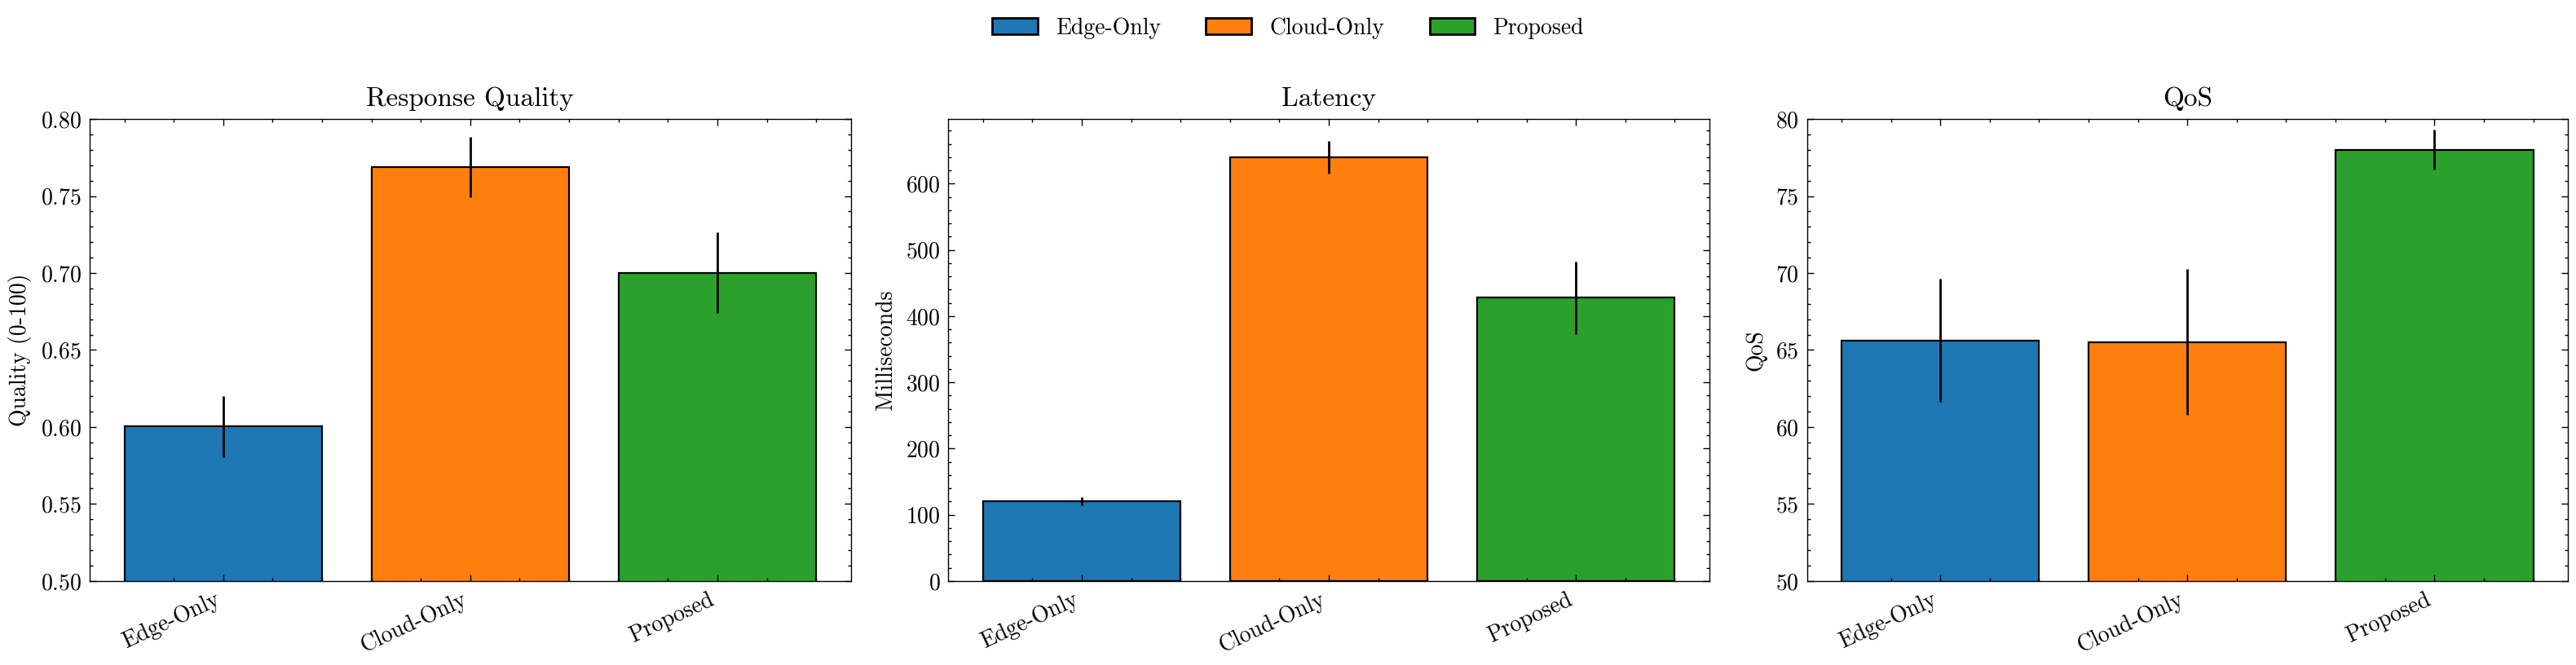

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import warnings

warnings.simplefilter('ignore')
plt.style.use(['science', 'no-latex'])

def collect_selected_metrics(row):
    if row["selected_arm"] == "edge":
        return pd.Series({
            "prompt": row["prompt"],
            "quality_score": row["edge_quality_score"],
            "latency_ms": row["edge_latency_ms"],
            "qos": row["pred_edge_qos"]
        })
    else:  # cloud
        return pd.Series({
            "prompt": row["prompt"],
            "quality_score": row["cloud_quality_score"],
            "latency_ms": row["cloud_latency_ms"],
            "qos": row["pred_cloud_qos"]
        })

all_policies = {}

all_policies['Proposed'] = test_ds.apply(collect_selected_metrics, axis=1)

all_policies['Edge-Only'] = pd.DataFrame({
    "prompt": test_ds["prompt"],
    "quality_score": test_ds["edge_quality_score"],
    "latency_ms": test_ds["edge_latency_ms"],
    "qos": test_ds["edge_qos"]
})

all_policies['Cloud-Only'] = pd.DataFrame({
    "prompt": test_ds["prompt"],
    "quality_score": test_ds["cloud_quality_score"],
    "latency_ms": test_ds["cloud_latency_ms"],
    "qos": test_ds["cloud_qos"]
})

results = []
for model in ['Edge-Only', 'Cloud-Only', 'Proposed']:
    results.append({
        'policy': model,
        'latency_mean': all_policies[model]['latency_ms'].mean(),
        'quality_mean': all_policies[model]['quality_score'].mean(),
        'qos_mean': all_policies[model]['qos'].mean(),
        'latency_std': all_policies[model]['latency_ms'].std(),
        'quality_std': all_policies[model]['quality_score'].std(),
        'qos_std': all_policies[model]['qos'].std(),
    })

summary = pd.DataFrame(results)
display(summary)

plt.figure(figsize=(16, 4), dpi=200)
palette = sns.color_palette("tab10", len(summary))
bar_colors = {policy: palette[i] for i, policy in enumerate(summary["policy"])}

# (a) Response Quality
ax1 = plt.subplot(1, 3, 1)
ax1.bar(summary["policy"], summary["quality_mean"], yerr=summary["quality_std"]*0.2, linewidth=0.8, edgecolor="black", color=[bar_colors[p] for p in summary["policy"]])
ax1.set_title("Response Quality")
ax1.set_ylabel("Quality (0-100)"); ax1.set_ylim(0.5, 0.8)
ax1.set_xticklabels(summary["policy"], rotation=25, ha="right")

# (b) Latency (ms)
ax2 = plt.subplot(1, 3, 2)
ax2.bar(summary["policy"], summary["latency_mean"], yerr=summary["latency_std"]*0.2, linewidth=0.8, edgecolor="black", color=[bar_colors[p] for p in summary["policy"]])
ax2.set_title("Latency")
ax2.set_ylabel("Milliseconds")
ax2.set_xticklabels(summary["policy"], rotation=25, ha="right")

# (c) QoS
ax3 = plt.subplot(1, 3, 3)
ax3.bar(summary["policy"], summary["qos_mean"], yerr=summary["qos_std"]*0.2, linewidth=0.8, edgecolor="black", color=[bar_colors[p] for p in summary["policy"]])
ax3.set_title("QoS")
ax3.set_ylabel("QoS"); ax3.set_ylim(50, 80)
ax3.set_xticklabels(summary["policy"], rotation=25, ha="right")

handles = [plt.Rectangle((0, 0), 1, 1, color=bar_colors[p], ec="black") for p in summary["policy"]]
labels = summary["policy"].tolist()
plt.figlegend(handles, labels, loc="upper center", ncol=len(summary), frameon=False, bbox_to_anchor=(0.5, 1.05))

plt.tight_layout(rect=[0, 0, 1, 0.95])


plt.show()

### 🏁 Conclusion: Intelligent Model Placement for Super-Agentic Systems

This experiment demonstrated how **model placement** — deciding *where* a model should run (Edge vs Cloud) — can be learned **automatically** using a data-driven approach.
By simulating latency and quality trade-offs and training a **multi-armed bandit regressor**, we built a system that dynamically selects the most suitable execution environment per prompt.

The results above highlight clear takeaways:

* ⚡ **Edge-only** policies deliver fast responses but suffer in quality.
* ☁️ **Cloud-only** policies maximize accuracy but incur significant latency.
* 🤖 **Our proposed bandit-based policy** learns to **balance both**, achieving the **highest overall QoS**, dynamically routing tasks based on context.


### 🌍 Why This Matters

In real-world **super-agentic architectures**, agents continuously interact with both **local** and **remote** compute.
Static rules (“short prompts → edge, long ones → cloud”) break down as workloads evolve.
Instead, learned placement policies adapt to:

* Real-time network conditions,
* Model version updates and degradation,
* User-level personalization (different tolerance for delay vs detail).

This enables **self-optimizing orchestration**, a core property of production-grade multi-agent systems.


### 🧠 Beyond Bandits — Advanced Research Directions

While we used an offline **multi-armed bandit (MAB)** regressor, several advanced research methods push this idea further:

1. **Contextual Bandits with Neural Embeddings** —
   Use transformer-based embeddings or state encoders to learn non-linear context–reward relationships (e.g., LinUCB [(Lin et al. 2012)](https://arxiv.org/pdf/1003.0146), NeuralUCB [(Zhou et al. 2019)](https://arxiv.org/pdf/1911.04462)).

2. **Reinforcement Learning for Placement** —
   Frame placement as a sequential decision problem (state = load, network, prompt type).
   Techniques: **Deep Q-Networks** [(Mnih et al. 2013)](https://arxiv.org/pdf/1312.5602), **PPO** [(Schulman et al. 2017)](https://arxiv.org/pdf/1707.06347), or **Actor–Critic** [(Han et al. 2020)](https://arxiv.org/pdf/2004.14288) models for adaptive orchestration. 

3. **Multi-Agent Scheduling Systems** —
   Each agent decides *locally* (Edge/Cloud/Hybrid) and coordinates through message passing, resembling **federated reinforcement learning**.

4. **Dynamic Resource-Aware Routing** —
   Combine placement with **cost and energy models**, using RL or **multi-objective optimization** to minimize latency, maximize accuracy, and respect power constraints.

5. **Graph-Based Placement** —
   Model the computation graph of multi-step reasoning and assign each node to optimal compute using **graph optimization** or **neural architecture search (NAS)** [(Zoph et al. 2020)](https://arxiv.org/pdf/1611.01578) style methods.

6. **Adaptive and Continual Learning** —
   Incorporate user feedback loops (RLHF-style) to continually improve placement decisions as environment and models evolve.


In essence, **model selection**, **intelligent routing**, and **dynamic placement** together form the cognitive backbone of super agents — systems that don’t just *use* intelligence, but *orchestrate* it across models, contexts, and environments to think, act, and adapt like living ecosystems of AI.
